In [1]:
import pandas as pd, numpy as np, numpy.linalg as nl, inspect, seaborn as sns, plotly, plotly.express as px, pickle, plotly.graph_objects as go, itertools
from tqdm import tqdm
from matplotlib.pyplot import *
from pathlib import Path
from sklearn.cluster import KMeans, AgglomerativeClustering,DBSCAN
import kneed
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report,precision_recall_fscore_support, normalized_mutual_info_score,confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics.cluster import contingency_matrix
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram, ward,single,complete
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC,LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier, AdaBoostClassifier,StackingClassifier
from pandas.api.types import is_numeric_dtype
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.image as mpimg

In [2]:
mapping = dict(np.flip(np.array([[0,'chevrolet_impala_2004-2005'],
    [1,  'dodge_grand caravan_2005-2006'],
    [2,  'ford_explorer_2001-2002'],
    [3,  'honda_accord_2005-2006'],
    [4,  'nissan_altima_2005-2006'],
    [5,  'toyota_camry_2002-2003'],
    [6,  'volkswagen_jetta_2002-2003'],
    [7,  'ford_mustang_2000-2001'],
    [8,  'ford_taurus_2002-2003'],
    [9,  'honda_odyssey_2005-2006']]),axis=1))

In [3]:
#Edit these with where you'd like the results to go or the data to come from
result_location = Path('results.csv')
data_dir = Path('../Data')
metadata = pd.read_csv(Path(data_dir,'train_data.csv'),header=None,names=['full_class','filename'])
metadata[['make','model','year']] = metadata['full_class'].str.split('_',expand=True)
metadata['class'] = metadata['full_class'].apply(lambda x: mapping[x])
metadata['class'] = metadata['class'].astype(int)
metadata['file_path'] = str(data_dir)+'/train_images/'+metadata['full_class']+'/' + metadata['filename']
features = pd.read_csv(Path(data_dir,'train_features.csv'),header=None)


In [4]:
STATE = 1

In [5]:
train_percentage = .8
dataset_percentage=1

x_train, x_test, y_df_train, y_df_test =  train_test_split(features.values,metadata,train_size=train_percentage*dataset_percentage, test_size=(1-train_percentage)*dataset_percentage,random_state=STATE,stratify=metadata['class'])
y_df_train.reset_index(inplace=True)
y_df_test.reset_index(inplace=True)
y_train, y_test = y_df_train['class'].values, y_df_test['class'].values

In [6]:
mlp_model_1 = MLPClassifier(alpha = .4, hidden_layer_sizes=[256,128,64,64],learning_rate_init=.004)
mlp_model_2 = MLPClassifier(alpha = .4, hidden_layer_sizes=[256,128,64,64],learning_rate_init=.004,learning_rate='adaptive')
svm_model = SVC(C=1.25,gamma=.12857142857142856,probability=True)
rf_model = RandomForestClassifier(max_depth=100,n_estimators=450)

In [7]:
estimators = [('Kmean_mlp',
               Pipeline([('Kmean',KMeans(n_clusters=400)),('pca',PCA(n_components=.99)),('scaler',MinMaxScaler()),('clf',mlp_model_1)])),
               ('plain_mlp',
               Pipeline([('pca',PCA(n_components=.99)),('scaler',MinMaxScaler()),('clf',mlp_model_2)])),
               ('SVM',
               Pipeline([('pca',PCA(n_components=.99)),('scaler',MinMaxScaler()),('clf',svm_model)])),
               ('RF',
               Pipeline([('pca',PCA(n_components=.99)),('scaler',MinMaxScaler()),('clf',rf_model)]))
               ]
stacked = StackingClassifier(estimators=estimators,n_jobs=-1,final_estimator=CalibratedClassifierCV())
stacked.fit(x_train,y_train)
df = pd.DataFrame()
full_calls = dict()
for name in stacked.named_estimators_.keys():
    model = stacked.named_estimators_[name]
    prediction = model.predict_proba(x_test)
    df[name] = prediction.argmax(axis=1)
    full_calls[name] = prediction

# stacked = StackingClassifier(estimators=estimators,n_jobs=-1,final_estimator=LogisticRegression())
# stacked.fit(x_train,y_train)


/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/tylman/anaconda3/envs/ketsu/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [8]:
scoring_items = ['accuracy','f1_weighted','roc_auc_ovr']

In [9]:
def load_model(model,loc=''):
    filname = list(Path(loc).rglob('*'+model+'*'))
    if len(filname) == 0:
        raise ValueError("Can't find the file!")
    if len(filname) >1:
        raise ValueError("Located too many items matching that search. Please try again. We found: {}".format(filname))
    filname = filname[0]
    with open(filname,'rb') as fil:
        temp = pickle.load(fil)
    return temp

In [10]:
y_pred = stacked.predict_proba(x_test)

In [11]:
def plot_confusion_matrix(CM,save=False, out_dir='.'):
    disp = ConfusionMatrixDisplay(confusion_matrix=CM)
    disp.plot()
    disp.ax_.set_title('Confusion Matrix')
    disp.ax_.set_xticklabels(disp.ax_.get_xticklabels(),rotation=90)
    if save:
        temp_out = Path(out_dir,'Final_CM.png')
        disp.figure_.savefig(temp_out,bbox_inches='tight')
    show()

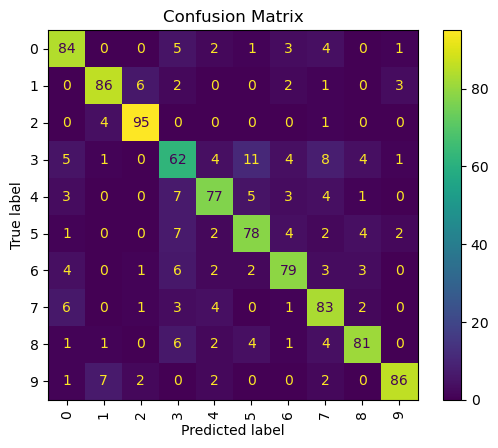

In [12]:
CM = confusion_matrix(y_test,y_pred.argmax(axis=1))
plot_confusion_matrix(CM,save=True)

In [13]:
acc = accuracy_score(y_test,y_pred.argmax(axis=1))
roc = roc_auc_score(pd.get_dummies(y_test),y_pred, multi_class='ovr')
f1  = f1_score(y_test,y_pred.argmax(axis=1), average='weighted')

In [14]:
acc

0.811

In [15]:
roc

0.9726455555555555

In [16]:
f1

0.8109798955837236

In [17]:
df['stack'] = y_pred.argmax(axis=1)

In [18]:
df['truth'] = y_test

In [19]:
pd.unique(df['plain_mlp'])

array([4, 8, 1, 9, 7, 3, 2, 6, 0, 5])

In [20]:

counts = [np.array([row[i] == row['truth'] for i in full_calls.keys()]).sum() for _, row in df.iterrows()]

In [21]:
df['counts'] = counts

In [22]:
df['correct'] = df['stack'] == df['truth']

In [23]:
better = df.loc[df['correct'] & (df['counts'] <= 1)]
better.to_csv('Stack_Better.csv')

In [24]:
super_better = df.loc[df['correct'] & (df['counts'] < 1)]
#better.to_csv('Stack_Better.csv')

In [25]:
super_better

,Kmean_mlp,plain_mlp,SVM,RF,stack,truth,counts,correct
73,0,6,7,7,4,4,0,True
871,5,8,0,7,3,3,0,True


In [26]:
worse = df.loc[~df['correct'] & (df['counts'] > 2)]
worse.to_csv('Stack_Worse.csv')

In [27]:
worse

,Kmean_mlp,plain_mlp,SVM,RF,stack,truth,counts,correct
167,8,8,3,8,3,8,3,False
329,8,8,5,8,5,8,3,False
450,7,7,0,7,0,7,3,False


In [28]:
def display_image(idx, images,ax=None):
    if ax is not None:
        ax.imshow(images[idx].reshape(32,32,3))
    else:
        imshow(mpimg.imread(name))

In [29]:
def draw_images(fil_names, x,y, save=False, out_dir='', title=''):
    fig, axs = subplots(x,y)
    for i in range(x*y):
        if (x ==1) or (y ==1):
            ax = axs[i]
        else:
            ax = axs[i//y,i%y]

        ax.imshow(mpimg.imread(fil_names.iloc[i]['file_path']))
        #display_image(int(df.iloc[i]['idx']),pd.read_csv(image_dir,), ax=ax)
        #score = df.iloc[i]['sil_score']
        ax.set_title('truth:{}'.format(fil_names.iloc[i]['class']))
        # if i%y == 0:
        #     cluster = int(df.iloc[i]['cluster'])
        ax.set_ylabel('called:{}'.format(fil_names.iloc[i]['called']))
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_xticklabels([])
    fig.suptitle(f'{title}')
    tight_layout()
    if save:
        savefig(Path(out_dir,f'{title}.png'))
    show()


In [30]:
idx = np.array(worse.index)

In [31]:
worse.shape

(3, 8)

In [44]:
better.shape

(85, 8)

In [33]:
super_better

,Kmean_mlp,plain_mlp,SVM,RF,stack,truth,counts,correct
73,0,6,7,7,4,4,0,True
871,5,8,0,7,3,3,0,True


In [34]:
plottable = y_df_test.reset_index().iloc[list(worse.index)][['file_path','class']]#.set_index(worse.index)
plottable['called'] = worse['stack']

In [35]:
worse

,Kmean_mlp,plain_mlp,SVM,RF,stack,truth,counts,correct
167,8,8,3,8,3,8,3,False
329,8,8,5,8,5,8,3,False
450,7,7,0,7,0,7,3,False


In [36]:
plottable

,file_path,class,called
167,../Data/train_images/ford_taurus_2002-2003/200...,8,3
329,../Data/train_images/ford_taurus_2002-2003/200...,8,5
450,../Data/train_images/ford_mustang_2000-2001/00...,7,0


In [37]:
y_test[list(worse.index)]

array([8, 8, 7])

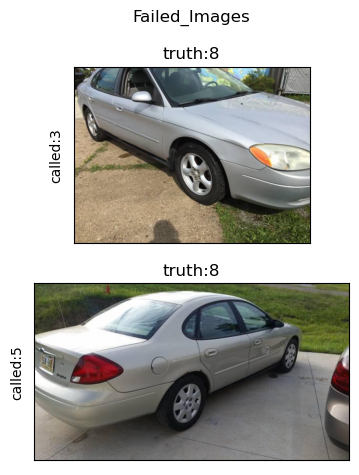

In [39]:
draw_images(plottable,2,1,save=True, title='Failed_Images')

In [40]:
plottable = y_df_test.reset_index().iloc[list(super_better.index)][['file_path','class']]#.set_index(super_better.index)
plottable['called'] = super_better['stack']

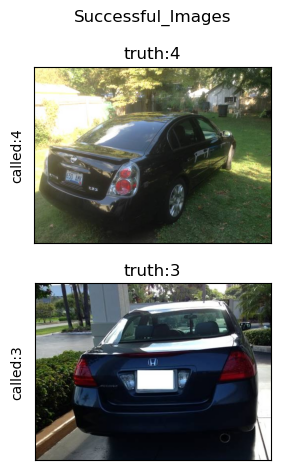

In [42]:
draw_images(plottable,2,1,save=True, title='Successful_Images')

In [45]:
max_call = pd.DataFrame()
for item in full_calls.keys():
    max_call[item+'_max'] = full_calls[item][idx].max(axis=1)

In [46]:
max_call.to_latex('maximum_of_bad_images.tex',index=False)

/tmp/ipykernel_11095/1732667194.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  max_call.to_latex('maximum_of_bad_images.tex',index=False)


In [47]:
super_better

,Kmean_mlp,plain_mlp,SVM,RF,stack,truth,counts,correct
73,0,6,7,7,4,4,0,True
871,5,8,0,7,3,3,0,True


In [48]:
plottable

,file_path,class,called
73,../Data/train_images/nissan_altima_2005-2006/0...,4,4
871,../Data/train_images/honda_accord_2005-2006/ho...,3,3


In [50]:
df.iloc[worse.index]

,Kmean_mlp,plain_mlp,SVM,RF,stack,truth,counts,correct
167,8,8,3,8,3,8,3,False
329,8,8,5,8,5,8,3,False
450,7,7,0,7,0,7,3,False
